In [74]:
import numpy as np
import matplotlib.pyplot as plt
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import random
from collections import deque

In [75]:
class SimplePolicy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(SimplePolicy, self).__init__()
        
        self.affine1 = nn.Linear(4, 16)
        self.dropout = nn.Dropout(p=0.6)
        self.affine2 = nn.Linear(16, 2)
        


    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

In [76]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight.data)

def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n


def compute_returns(rewards, gamma):
    rewards_rev = np.array([gamma**i * rewards[i] 
                  for i in range(len(rewards))])
    rewards_rev = rewards_rev.cumsum()[::-1] 
    #rewards_rev=(rewards_rev-np.mean(rewards_rev))/np.std(rewards_rev)
    return rewards_rev



def reinforce(env, policy_model, seed, learning_rate,
              number_episodes,
              max_episode_length,
              gamma, verbose=True):
    # set random seeds (for reproducibility)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    env.seed(seed)
    
    optimizer = torch.optim.Adam(policy_model.parameters(), 
                           lr=1e-2)
    
    total_rewards=[]
    
    for ep in range(number_episodes):
        rewards=[]
        current_state=env.reset()    
        log_probs=[]          
        done = False
        
        for i in range(max_episode_length):    
            
            action_probs = policy_model( torch.from_numpy(current_state).float().unsqueeze(0))
            m = torch.distributions.Categorical(action_probs)
            action = m.sample()
            test=m.log_prob(action)           
            log_probs.append(test) 
            
            next_state, reward, done,info = env.step(action.item())       
            rewards.append(reward)
            current_state = next_state
            
            if done==True:
                break
                
        total_rewards.append(np.sum(rewards))       
        returns = compute_returns(rewards, gamma)
        
        loss=[]
        for log_prob_, re in zip(log_probs, returns):
            loss.append(-log_prob_ * re)
            
        optimizer.zero_grad()    
        loss = np.sum(loss)
        loss.backward()
        optimizer.step()
        
        if ep%500==0:
            print(ep)

    return policy_model,total_rewards



def compute_returns_naive_baseline(rewards, gamma):
    rewards_rev = np.array([gamma**i * rewards[i] 
                  for i in range(len(rewards))])
    rewards_rev = rewards_rev.cumsum()[::-1] 
    rewards_rev=(rewards_rev-np.mean(rewards_rev))/np.std(rewards_rev)
    return rewards_rev


def reinforce_naive_baseline(env, policy_model, seed, learning_rate,
                             number_episodes,
                             max_episode_length,
                             gamma, verbose=True):
    # set random seeds (for reproducibility)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    env.seed(seed)
    optimizer = torch.optim.Adam(policy_model.parameters(), 
                           lr=1e-2)
    
    total_rewards=[]
    
    for ep in range(number_episodes):
        rewards=[]
        current_state=env.reset()    
        log_probs=[]          
        done = False
        
        for i in range(max_episode_length):    
            
            action_probs = policy_model( torch.from_numpy(current_state).float().unsqueeze(0))
            m = torch.distributions.Categorical(action_probs)
            action = m.sample()
            test=m.log_prob(action)           
            log_probs.append(test) 
            
            next_state, reward, done,info = env.step(action.item())       
            rewards.append(reward)
            current_state = next_state
            
            if done==True:
                break
                
        total_rewards.append(np.sum(rewards))       
        returns = compute_returns_naive_baseline(rewards, gamma)
        
        loss=[]
        for log_prob_, re in zip(log_probs, returns):
            loss.append(-log_prob_ * re)
            
        optimizer.zero_grad()    
        loss = np.sum(loss)
        loss.backward()
        optimizer.step()
        
        if ep%500==0:
            print(ep)

    return policy_model,total_rewards



def run_reinforce():
    env = gym.make('CartPole-v1')
    policy_model = SimplePolicy(s_size=env.observation_space.shape[0], h_size=50, a_size=env.action_space.n)
    policy, scores = reinforce(env=env, policy_model=policy_model, seed=42, learning_rate=1e-2,
                               number_episodes=1500,
                               max_episode_length=1000,
                               gamma=1.0,
                               verbose=True)
    
    #Fromhttps://github.com/andrecianflone/rl_at_ammi
    moving_avg_scores = moving_average(a =scores, n = 50)
    plt.figure(figsize=(10,5))
    plt.plot(scores , label = "Scores")
    plt.plot(moving_avg_scores, label = "Moving Average, w = 50")
    plt.title("Q4 Reinforce Learning Cure")
    plt.xlabel("Episode Number")
    plt.ylabel("Score")
    plt.legend()


def investigate_variance_in_reinforce():
    env = gym.make('CartPole-v1')
    all_scores = []
    policy = SimplePolicy()
    for run in range(5):
        seeds = np.random.randint(1000)
        policy.apply(weights_init)
        _, scores = reinforce(env=env, policy_model=policy , seed=seeds, learning_rate=1e-2,
                               number_episodes=1500,
                               max_episode_length=1000,
                               gamma=1.0,
                               verbose=True)
        all_scores.append(scores)

     ##Fromhttps://github.com/andrecianflone/rl_at_ammi   
    smoothed_scores = [moving_average(s, 50) for s in all_scores]
    smoothed_scores = np.array(smoothed_scores)
    mean = smoothed_scores.mean(axis=0)
    std = smoothed_scores.std(axis=0)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = np.arange(1, len(mean)+1)
    ax.plot(x, mean, '-', color='blue')
    ax.fill_between(x, mean - std, mean + std, color='blue', alpha=0.2)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title('REINFORCE averaged over 5 seeds')
    plt.show()
    
    return 
        
    


def run_reinforce_with_naive_baseline():
    env = gym.make('CartPole-v1')
    policy_model = SimplePolicy(s_size=env.observation_space.shape[0], h_size=50, a_size=env.action_space.n)
    policy, scores = reinforce_naive_baseline(env=env, policy_model=policy_model, seed=42, learning_rate=1e-2,
                               number_episodes=1500,
                               max_episode_length=1000,
                               gamma=1.0,
                               verbose=True)
    
    moving_avg_scores = moving_average(a =scores, n = 50)
    plt.figure(figsize=(10,5))
    plt.plot(scores , label = "Scores")
    plt.plot(moving_avg_scores, label = "Moving Average, w = 50")
    plt.title("Q4 Reinforce Learning Cure")
    plt.xlabel("Episode Number")
    plt.ylabel("Score")
    plt.legend()


# if __name__ == '__main__':
#     run_reinforce()
#     all_= investigate_variance_in_reinforce()
# #     run_reinforce_with_naive_baseline(mean, std)


0
500
1000


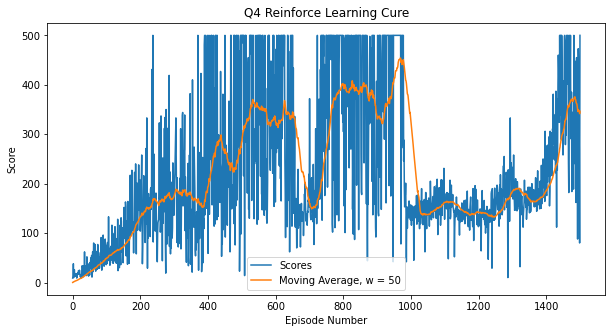

In [77]:
run_reinforce()

<ipython-input-76-55fbbf60d968>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight.data)


0
500
1000
0
500
1000
0
500
1000
0
500
1000
0
500
1000


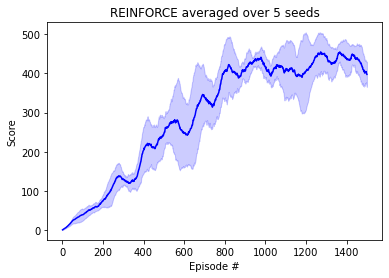

In [78]:
investigate_variance_in_reinforce()

0
500
1000


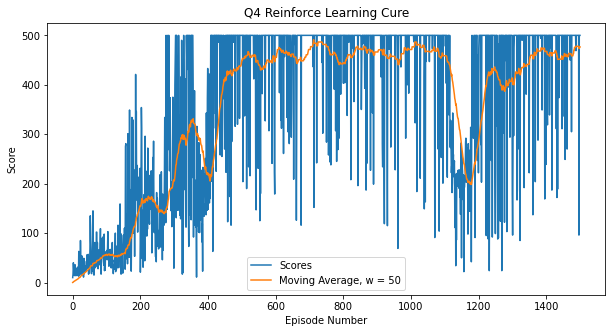

In [79]:
run_reinforce_with_naive_baseline()